# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import datetime
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration & Preprocessing
In this section we will explore the data loaded (porfolio, profile & transcript). In addition, the df's are going to be preprocessed and this is the part were we will transform our data to be loaded into the db and later be fed into ML pipelines.

### 1a. Portofolio

In [2]:
print(portfolio.shape)
portfolio.head(10)

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [4]:
# check for any nulls existing in this df.
# we should expect zeros since the subset contains only 10 rows which is printed in the cell above and contains no nulls.
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

On first thoughts we could turn each channel type into a column with 0's and 1's.
Also we could convert the encoded id's into integers.

In [5]:
# checking the types of all columns.
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [6]:
# check the number of unique offers.
portfolio.id.nunique()

10

lets also convert offer_type column into categorical variables.

In [7]:
# what are the available offer_types
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
def id_mapper(df):
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

def preprocess(df):
    # use int ids instead of hashes.
    id_encoded = id_mapper(df)
    del df['id']
    df['id'] = id_encoded
    df.set_index('id', inplace=True)
    
    return df
    
def preprocess_portfolio(portfolio):
    
    # takea clone of portfolio
    df = portfolio.copy()
    df = preprocess(df)
    
    # get dummies for offer type and channels
    offer_type = pd.get_dummies(df['offer_type'])
    
    # https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
    channels = pd.get_dummies(df['channels'].apply(pd.Series).stack()).sum(level=0)
    
    # drop the old columns and add the new dummy columns
    df.drop(columns=['channels', 'offer_type'], inplace=True)
    df = pd.concat([channels, df, offer_type], axis=1)
    
    return df
    
clean_portfolio = preprocess_portfolio(portfolio)

In [9]:
clean_portfolio.head()

,email,mobile,social,web,reward,difficulty,duration,bogo,discount,informational
id,,,,,,,,,,
1,1,1,1,0,10,10,7,1,0,0
2,1,1,1,1,10,10,5,1,0,0
3,1,1,0,1,0,0,4,0,0,1
4,1,1,0,1,5,5,7,1,0,0
5,1,0,0,1,5,20,10,0,1,0


### 1b. profile

In [10]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
profile.id.nunique()

17000

In [13]:
profile.duplicated().sum()

0

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


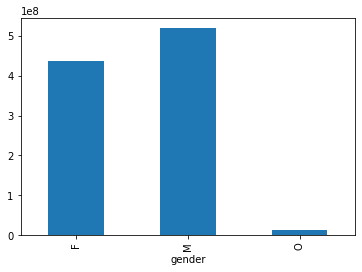

In [15]:
# total income earned grouped by gender
# this doesn't tell much since the count of gender are not equal. We should try to normalize it.
profile.groupby(['gender']).sum()['income'].plot(kind='bar');

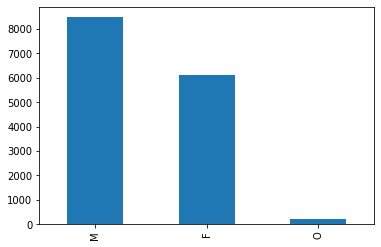

In [16]:
# there are more males then other genders.
profile['gender'].value_counts().plot(kind='bar');

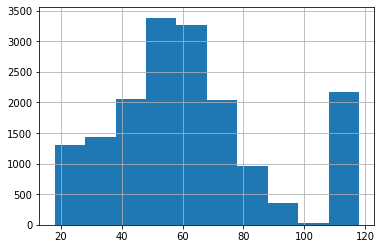

In [32]:
profile['age'].hist();

#### What is mean age across different genders?
It seems across different genders it's around the 50's

In [17]:
# it seems the median is the same 
profile[['gender', 'age']].groupby(['gender']).mean()

,age
gender,
F,57.544950
M,52.116690
O,54.400943


#### How is the income across age?
there seems to be pattern that income increases with age, however there are some exceptions.

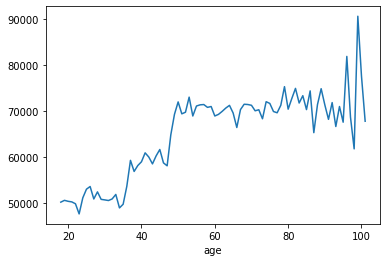

In [18]:
profile.groupby(['age'])['income'].mean().plot(kind='line');

In [19]:
# it seems that the age 118 has the highest count.
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [20]:
# This age seems to be untrusted because it's contributing to a lot of empty values.
# todo is there a way of filling in these data accurately without dropping the null rows? 
profile.query('age == 118')

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [21]:
# It seems all of the missing values are coming from this age.
print(profile.query('age == 118').isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [22]:
noise_data_idx = profile.query('age == 118').index
profile.drop(index=noise_data_idx).isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

#### Plot the distribution of income range
With qcut we ask pandas to specify the bins in order to have an evenly distribution.

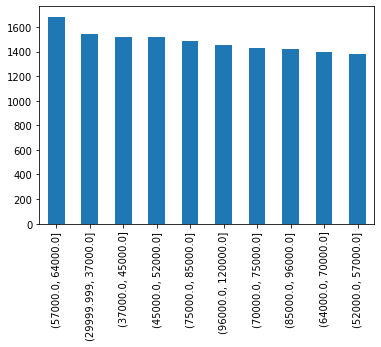

In [23]:
# spreading the income over ranges, to check how offers are affected by income.
# only for visualization and that's why we are dropping the null.
dropped_nulls = profile.drop(index=noise_data_idx)
income_range = pd.qcut(dropped_nulls['income'], q=10)
income_range.value_counts().plot(kind='bar');

In [25]:
def preprocess_profile(profile):
    df = profile.copy()
    
    # lets drop the noise entries such as 118 ages.
    # todo is there a way of filling in these data accurately without dropping the null rows? 
    noise_data_idx = df.query('age == 118').index
    df.drop(index=noise_data_idx, inplace=True)
    
    # preprocessing translates the ids into ints instead of hashes and makes the id the index.
    df = preprocess(df)
    
    # https://dfrieds.com/data-analysis/bin-values-python-pandas.html
    df['age_range'] = pd.qcut(df['age'], q=[0, .05, .1, .2, .4, .6, 1])
    age_decade = pd.get_dummies(df['age_range'], prefix='age_range', prefix_sep='_')
    
    # split gender into dummies. Since no missing values exist after removing 118, this should be safe.
    gender = pd.get_dummies(df['gender'], prefix='gender', prefix_sep='_')
    
    # Parse the date.
    dt = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    df['became_member_year'] = dt.dt.year
    df['became_member_month'] = dt.dt.month
    df['became_member_day'] = dt.dt.day
    
    # lets keep track of how long this user has been a member.
    df['member_duration'] = (datetime.datetime.today().date() - dt.dt.date).dt.days
    
    # spreading the income over ranges, to check how offers are affected by income.
    df['income_range'] = pd.qcut(df['income'], q=10)
    income_range = pd.get_dummies(df['income_range'], prefix='income_range')
    
    # add the dummies to our profile.
    df = pd.concat([df, age_decade, gender, income_range], axis=1)
    
    return df

In [26]:
processed_profile = preprocess_profile(profile)

In [27]:
processed_profile.head()

,gender,age,became_member_on,income,age_range,became_member_year,became_member_month,became_member_day,member_duration,income_range,...,"income_range_(29999.999, 37000.0]","income_range_(37000.0, 45000.0]","income_range_(45000.0, 52000.0]","income_range_(52000.0, 57000.0]","income_range_(57000.0, 64000.0]","income_range_(64000.0, 70000.0]","income_range_(70000.0, 75000.0]","income_range_(75000.0, 85000.0]","income_range_(85000.0, 96000.0]","income_range_(96000.0, 120000.0]"
id,,,,,,,,,,,,,,,,,,,,,
1,F,55,20170715,112000.0,"(51.0, 59.0]",2017,7,15,1215,"(96000.0, 120000.0]",...,0,0,0,0,0,0,0,0,0,1
2,F,75,20170509,100000.0,"(59.0, 101.0]",2017,5,9,1282,"(96000.0, 120000.0]",...,0,0,0,0,0,0,0,0,0,1
3,M,68,20180426,70000.0,"(59.0, 101.0]",2018,4,26,930,"(64000.0, 70000.0]",...,0,0,0,0,0,1,0,0,0,0
4,M,65,20180209,53000.0,"(59.0, 101.0]",2018,2,9,1006,"(52000.0, 57000.0]",...,0,0,0,1,0,0,0,0,0,0
5,M,58,20171111,51000.0,"(51.0, 59.0]",2017,11,11,1096,"(45000.0, 52000.0]",...,0,0,1,0,0,0,0,0,0,0


#### What does the age distribution look like after removing the nulls?

<AxesSubplot:>

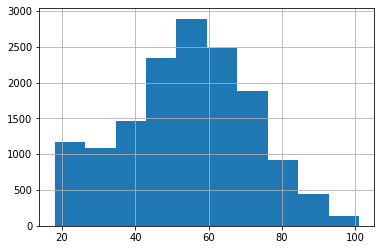

In [38]:
# lets see the distribution after age 118 was removed.
processed_profile['age'].hist()

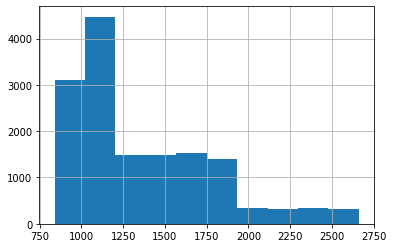

In [40]:
processed_profile['member_duration'].hist();